<img align="right" src="https://raw.githubusercontent.com/GT4SD/gt4sd-core/main/docs/_static/gt4sd_logo.png" alt="logo" width="100" height="100"/>

##  Demo: The Generative Toolkit for Scientific Discovery


In [5]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.QED import qed
import pandas as pd
import mols2grid

### Let us have a look at a novel, AI-generated DDR1 kinase inhibitor

The following molecule is one of the first AI-generated molecules that was demonstrated to have pharmacokinetic activity in mice. 
The molecule was proposed by the GENTRL algorithm, a variational autoencoder that was optimized with tensorial reinforcement learning.

Throughout the tutorial, we will call the molecule 
- **gentrl_ddr1**

since it was developed to inhibit protein kinase DDR1.



For details on this molecule and its relation to already marketed drugs (e.g., Ponatinib), please see:

```txt
Zhavoronkov, A., Ivanenkov, Y. A., Aliper, A., Veselov, M. S., Aladinskiy, V. A., Aladinskaya, A. V., ... & Aspuru-Guzik, A. (2019). Deep learning enables rapid identification of potent DDR1 kinase inhibitors. Nature biotechnology, 37(9), 1038-1040.

Walters, W. P., & Murcko, M. (2020). Assessing the impact of generative AI on medicinal chemistry. Nature biotechnology, 38(2), 143-145.
```

In [12]:
gentrl_ddr1_smi = 'Cc1cc2ON=C(Nc3cccc(C(F)(F)F)c3)c2cc1C#Cc1cnc2cccnn12'
gentrl_ddr1_mol = Chem.MolFromSmiles(gentrl_ddr1_smi)
gentrl_ddr1_qed = qed(gentrl_ddr1_mol)

mols2grid.display(
    pd.DataFrame({
        'SMILES': [gentrl_ddr1_smi], 'Name': ['gentrl_ddr1'], 'QED': [gentrl_ddr1_qed],
        'QED Val': [f'QED = {x:.3f}' for x in [gentrl_ddr1_qed]]
    }),
    size=(800,250), tooltip=['SMILES', 'Name', 'QED'], subset=['Name', 'img', 'QED Val']
)

# GT4SD Discovery usecase
## Find a similar molecule with improved drug-likeness

### **Goal:** 
The goal of this tutorial is to find a molecule that is **similar** to **gentrl_ddr1** but has a higher **drug-likeness** than it.

- We measure **similarity** with a structural similarity measure, the Tanimoto similarity of Morgan fingerprints (ECFP; *Rogers and Hahn, 2012*).
- We measure **drug-likeness** using the QED endpoint in `rdkit`.


NOTE: This is obviously is a highly artificial & simplistic discovery task but it gives us the opportunity to showcase many of the generative algorithms implemented in the GT4SD.



Import the algorithms and helper functions:

In [7]:
import logging, sys
logging.disable(sys.maxsize)
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

from gt4sd.algorithms.generation.moler import MoLeR, MoLeRDefaultGenerator
from gt4sd.algorithms.generation.torchdrug import TorchDrugGenerator, TorchDrugGCPN, TorchDrugGraphAF

from gt4sd.algorithms.conditional_generation.guacamol import GuacaMolGenerator, MosesGenerator
from gt4sd.algorithms.conditional_generation.guacamol import (
    VaeGenerator, AaeGenerator, OrganGenerator, GraphMCTSGenerator
)
from gt4sd.algorithms.conditional_generation.regression_transformer import (
    RegressionTransformer, RegressionTransformerMolecules
)
from tqdm import tqdm
from selfies import encoder
import pandas as pd
from rdkit.DataStructs import FingerprintSimilarity
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


## First attempt: 
Using unconditional molecular generative models that draw "random" samples from a learned chemical space

In [8]:

# Inititalize algorithms
moler_config = MoLeRDefaultGenerator()
moler_alg = MoLeR(configuration=moler_config)

organ_config = OrganGenerator()
organ_alg = GuacaMolGenerator(configuration=organ_config, target={})

vae_config = VaeGenerator()
vae_alg = GuacaMolGenerator(configuration=vae_config, target={})

aae_config = AaeGenerator()
aae_alg = GuacaMolGenerator(configuration=aae_config, target={})

gcpn_config = TorchDrugGCPN(algorithm_version='zinc250k_v0')
gcpn_alg = TorchDrugGenerator(configuration=gcpn_config)

graphaf_config = TorchDrugGraphAF(algorithm_version='zinc250k_v0')
graphaf_alg = TorchDrugGenerator(configuration=graphaf_config)

unconditional_algorithms = [moler_alg, organ_alg, vae_alg, aae_alg, gcpn_alg, graphaf_alg]
unconditional_names = ['MoLeR', 'ORGAN', 'VAE', 'AAE', 'GCPN', 'GraphAF']

# To compute similarity to our molecule
gentrl_ddr1_fp = GetMorganFingerprintAsBitVect(gentrl_ddr1_mol, radius=2)
get_tani = lambda x: FingerprintSimilarity(
    gentrl_ddr1_fp,
    GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=2)
)

In [9]:
# Sample from the models (this will take a while)

num_samples = 100 # number of molecules sampled per model
mol_df = pd.DataFrame()
batch_size = 32

for model,name in tqdm(
    zip(unconditional_algorithms, unconditional_names), total=len(unconditional_algorithms),
    desc='Processing algorithm number:'
):
    smiles = []
    while len(smiles) < num_samples:
        smis = list(model.sample(batch_size))
        smiles.extend([s for s in smis if Chem.MolFromSmiles(s) and s not in smiles])
    mol_df = pd.concat([
        mol_df,
        pd.DataFrame({
            'smiles': smiles, 
            'algorithm': [name]*len(smiles), 
            'qed': list(map(lambda x: qed(Chem.MolFromSmiles(x)), smiles)),
            'similarity': list(map(get_tani, smiles))
        })
    ], axis=0
    )
    

Processing algorithm number::   0%|                                                                                                                                                   | 0/6 [00:00<?, ?it/s]

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-04-22 19:12:58.390240: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:12:58.424609: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:12:58.446971: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:12:58.465264: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:12:58.468405: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:12:58.500614: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9d4886db00 initialized for platform 

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-04-22 19:13:18.260301: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:18.265921: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:18.271743: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:18.283206: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:18.300569: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:18.312454: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9d538c17f0 initialized for platform 

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-04-22 19:13:35.632602: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:35.634039: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:35.654328: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:35.677429: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:35.690653: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9d64be7640 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-22 19:13:35.691480: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host

Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl


2022-04-22 19:13:55.476711: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:55.481483: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:55.482600: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:55.489039: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:55.507332: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 19:13:55.523733: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9d586264d0 initialized for platform 

Generating mols: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 37.94it/s]

Generating mols: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 39.65it/s]

Generating mols: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 38.37it/s]

Generating mols: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 40.00it/s]

Generating mols: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20

Generating samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 52.17it/s]

Generating samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 51.12it/s]

Processing algorithm number:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [09:51<00:00, 98.59s/it]


Text(0.5, 1.0, 'QED of generated molecules (n=100)')

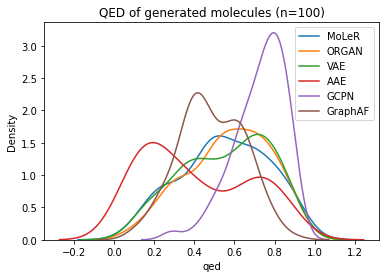

In [11]:
# Plot QED per model
for model in mol_df.algorithm.unique():
    tdf = mol_df[mol_df.algorithm==model]
    sns.distplot(tdf['qed'], label=model, hist=False)
    
plt.legend()
plt.title(f'QED of generated molecules (n={num_samples})')

Text(0.5, 1.0, 'Similarity of generated molecules (n=100)')

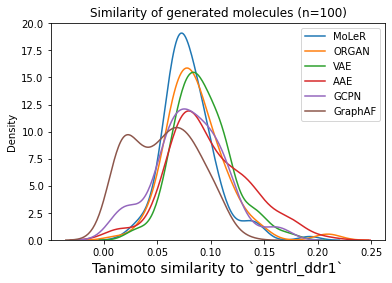

In [18]:
# Plot QED per model
for model in mol_df.algorithm.unique():
    tdf = mol_df[mol_df.algorithm==model]
    sns.distplot(tdf['similarity'], label=model, hist=False)
    
plt.legend()
plt.xlabel('Tanimoto similarity to `gentrl_ddr1`', size=14)
plt.title(f'Similarity of generated molecules (n={num_samples})')

This is a start but not great, so we have to improve!

In [153]:
# Conditional approaches

# TODO: These models just run forever
config = SMILESGAGenerator()
target = {"tanimoto_scorer": {"target": 0.0, 'target_smile':gentrl_ddr1_smi}}
algorithm = GuacaMolGenerator(configuration=config, target=target)
list(algorithm.sample(1))


config = GraphMCTSGenerator()
target = {"tanimoto_scorer": {"target": 0.0, 'target_smile':gentrl_ddr1_smi}}
target = {"qed_scorer": {"target": 0.5}}
algorithm = MosesGenerator(configuration=config, target=target)
list(algorithm.sample(1))
config = SMILESGAGenerator()
target = {"tanimoto_scorer": {"target": 0.1, 'target_smile': gentrl_ddr1_smi}}
algorithm = GuacaMolGenerator(configuration=config, target=target)







Help on class tqdm in module tqdm.std:

class tqdm(tqdm.utils.Comparable)
 |  tqdm(*_, **__)
 |  
 |  Decorate an iterable object, returning an iterator which acts exactly
 |  like the original iterable, but prints a dynamically updating
 |  progressbar every time a value is requested.
 |  
 |  Method resolution order:
 |      tqdm
 |      tqdm.utils.Comparable
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __bool__(self)
 |  
 |  __del__(self)
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, exc_type, exc_value, traceback)
 |  
 |  __hash__(self)
 |      Return hash(self).
 |  
 |  __init__(self, iterable=None, desc=None, total=None, leave=True, file=None, ncols=None, mininterval=0.1, maxinterval=10.0, miniters=None, ascii=None, disable=False, unit='it', unit_scale=False, dynamic_ncols=False, smoothing=0.3, bar_format=None, initial=0, position=None, postfix=None, unit_divisor=1000, write_bytes=None, lock_args=None, nrows=None, colour=None, delay=0, gui=False, **kwargs

In [22]:
from gt4sd.algorithms.conditional_generation.guacamol import MosesGenerator, GuacaMolGenerator, OrganGenerator


"""
Plain generators: Sample 100 molecules each and apply filter
- MoLeR
- TorchDrug GCPN ('zinc250k')
- Moses: AAE, VAE, Organ, SMILESGA, GraphMCTS

Conditional:
- ReinventGenerator (?)
- TorchDrug GCPN ('qed')
- TorchDrug GraphAF ('qed')

Scaffold:
- MoLeR
- RegressionTransformer (prepare)
"""

config = MoLeRDefaultGenerator()
algorithm = MoLeR(configuration=config)
list(algorithm.sample(10))


# config = OrganGenerator()
# algorithm = GuacaMolGenerator(configuration=config, target={})
# list(algorithm.sample(1))

13:32:28   runnning MoLeR with configuration=MoLeRDefaultGenerator(algorithm_version='v0', scaffolds='', num_samples=32, beam_size=1, seed=0, num_workers=6)
13:32:28   ensure artifacts for the application are present.
13:32:28   starting syncing
13:32:29   syncing complete
13:32:29   running MoLeR...
Loading a trained model from: /Users/jab/.gt4sd/algorithms/generation/MoLeR/MoLeRDefaultGenerator/v0/GNN_Edge_MLP_MoLeR__2022-02-24_07-16-23_best.pkl
13:32:29   Initialising TraceDataset.
13:32:29   Initialising TraceDataset.
13:32:29   Initialising TraceDataset.
13:32:29   Initialising TraceDataset.
13:32:29   Initialising TraceDataset.
13:32:29   Initialising TraceDataset.


2022-04-22 13:32:29.533855: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 13:32:29.533863: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 13:32:29.560978: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 13:32:29.565333: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 13:32:29.571646: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-22 13:32:29.602658: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8bade1f790 initialized for platform 

13:32:42   MoLeR run completed


['O=C1C2=CC=C(C3=CC=CC=C3)C=C=C2OC2=CC=CC=C12',
 'CC(=O)NC1=NC2=CC(OCC3=CC=CN(CC4=CC=C(Cl)C=C4)C3=O)=CC=C2N1',
 'CCN1C(=O)C2=CC=CC=C2N=C1NC(C)C(=O)NCC(=O)N=[N+]=[N-]',
 'CC(=O)N1CCCC1C1=NC2=CC=C(C(C)(C)CCCC(C)C)C=C2NC1=NC1=CC=C(O)C=C1',
 'N=C(N)NCCCCOC1=CC=C(Br)C(Cl)=N1',
 'O=C1C2=CC=C(C3=NN=CO3)C=C2N=CN1CC1=CC=C(C2=CC=CC=C2)C=C1',
 'O=CCCCCCN1C=CC2=CC=CC=C21',
 'CCOC(=O)C1=CC2=CC(CC(C)C)=CC=C2N=C1C1=CC=C(Br)C=C1',
 'CC1=C(C#N)C=C(NC(=O)NC2CCCCC2)N1CC#N',
 'CC1=CNN=C1NC(=O)COC1=CC=C(Cl)C=C1Cl']

In [ ]:
config = RegressionTransformerMolecules(search='greedy')
target = f"<esol>[MASK][MASK][MASK][MASK][MASK]|{encoder(smi)}"
esol_predictor = RegressionTransformer(configuration=config, target=target)
score = list(esol_predictor.sample(1))[0]
print(f'\nFor Buturuon, the predicted ESOL is {score}')

#### Ok, we can see that the prediction was decently close but not perfect
#### Now let us try to improve Buturuon to a molecule with higher solubility
#### Note, that we will use the same model to do so!


#### We simply set the hyperparameters for the search and mask undesired parts of the molecule

In [ ]:
config = RegressionTransformerMolecules(search='sample', temperature=2, tolerance=5)
target = "<esol>-3.534|[C][C][Branch1_3][Ring1][C][#C][N][Branch1_3][epsilon][C][C][Branch1_3][epsilon][MASK][MASK][MASK][MASK][C][=C][Branch1_3][epsilon][Cl][C][=C][Ring1][Branch1_2]"

In [ ]:
esol_generator = RegressionTransformer(
    configuration=config, target=target
)
generations = list(esol_generator.sample(5))
generations

In [ ]:
mols2grid.display(
    [Chem.MolFromSmiles(smi)] + [Chem.MolFromSmiles(s) for s,p in generations], 
    legends=[f'Buturon - Predicted ESOL: {score}'] + [f'Predicted ESOL = {p:.3f}' for s,p in generations],
    fixedBondLength=200
)

Chem.Draw.MolsToGridImage(
    ,
    legends=[f'Buturon - Predicted ESOL: {score}'] + [f'Predicted ESOL = {p:.3f}' for s,p in generations]
)


In [ ]:
print('\033[1m' '\t\t\t****Buturuon-inspired molecules with a higher solubility score*** ')
result = pd.DataFrame({
    'SMILES': [smi] + [s for s,p in generations],
    'Name': ['Buturon'] + 5*['Novel (from RT)'],
    'ESOL': [score] + [round(p, 3) for s,p in generations]
})
mols2grid.display(
    result, tooltip=['Name', 'SMILES', 'ESOL'],
    fixedBondLength=25, n_cols=6, width="100%", height=None,
    name='Bla'
)